In [1]:
%load_ext google.cloud.bigquery
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from util import *
from imblearn.over_sampling import SMOTE

# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information from over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 15 years ago. So if today is 2024.05.17 then the weather we want to forecast is for the date 2009.05.18. You are supposed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to use BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck in the first part, you can use the replacement data provided in the second part

In [4]:
# %%bigquery
# SELECT
# *,
# FROM `bigquery-public-data.samples.gsod`
# LIMIT 20


## Part 1

### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2005 till 2009 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [3]:
%%bigquery climate_data_df
SELECT *,
CONCAT(year, '-', month, '-', day) AS date
FROM `bigquery-public-data.samples.gsod` AS climate_data
WHERE climate_data.year BETWEEN 2005 AND 2009 AND climate_data.station_number BETWEEN 725300 AND 726300;

# climate_data_df = pd.read_csv("my_climate_data_df.csv")


Downloading: 100%|██████████| 377784/377784 [00:18<00:00, 20076.52rows/s]


### 2. Task 
From here you want to work with the data from all stations 725300 to 725330 that have information from 2005 till 2009. 

In [27]:
# Filter data
climate_data_df = climate_data_df[climate_data_df["station_number"] <= 725330]

Do a first analysis of the remaining dataset, clean or drop data depending on how you see appropriate. 

### Handling duplicates

In [28]:
# Original data length minus data length without duplicates
duplicate_count = len(climate_data_df) - len(climate_data_df.drop_duplicates())
duplicate_count

0

### Looking for class balance

In [29]:
climate_data_df["snow"].value_counts(normalize=True)

False    0.881847
True     0.118153
Name: snow, dtype: float64

We have imbalanced data -> We should use over- or under sampling methods in a real scenario. (for ex. SMOTE)

### Handling missing values and drop unnecessary columns

In [30]:
# Display the columns with the most missing values
round(climate_data_df.isnull().sum().sort_values(ascending=False) / len(climate_data_df), 2)

min_temperature_explicit              1.00
min_temperature                       1.00
snow_depth                            0.97
num_mean_station_pressure_samples     0.95
mean_station_pressure                 0.95
max_gust_wind_speed                   0.37
mean_sealevel_pressure                0.10
num_mean_sealevel_pressure_samples    0.10
total_precipitation                   0.01
max_sustained_wind_speed              0.00
mean_wind_speed                       0.00
num_mean_wind_speed_samples           0.00
mean_visibility                       0.00
num_mean_visibility_samples           0.00
num_mean_dew_point_samples            0.00
mean_dew_point                        0.00
max_temperature                       0.00
max_temperature_explicit              0.00
rain                                  0.00
snow                                  0.00
fog                                   0.00
hail                                  0.00
thunder                               0.00
tornado    

In [31]:
# Drop the columns with more that 60 % missing values (and the date columns that we don't need anymore)
climate_data_df_filtered = climate_data_df.drop(columns=["day",
                                                         "month",
                                                         "year",
                                                         "min_temperature_explicit",
                                                         "min_temperature",
                                                         "snow_depth",
                                                         "num_mean_station_pressure_samples",
                                                         "mean_station_pressure"])

In [32]:
climate_data_df_filtered.describe().T

,count,mean,std,min,25%,50%,75%,max
station_number,18129.0,725316.962050,8.979529,725300.000000,725314.000000,725316.000000,725326.000000,725330.000000
wban_number,18129.0,72766.474488,39561.090384,3887.000000,14842.000000,99999.000000,99999.000000,99999.000000
mean_temp,18129.0,51.999636,19.392603,-16.200001,36.299999,53.799999,69.099998,92.000000
num_mean_temp_samples,18129.0,23.574163,1.817230,4.000000,24.000000,24.000000,24.000000,24.000000
mean_dew_point,18127.0,41.605108,18.494937,-23.500000,27.500000,42.599998,57.200001,79.099998
num_mean_dew_point_samples,18127.0,23.553704,1.857548,4.000000,24.000000,24.000000,24.000000,24.000000
mean_sealevel_pressure,16291.0,1016.937585,6.920370,985.299988,1012.799988,1016.700012,1020.900024,1044.199951
num_mean_sealevel_pressure_samples,16291.0,21.682217,3.198832,4.000000,20.000000,23.000000,24.000000,24.000000
mean_visibility,18126.0,8.699388,1.730177,0.600000,7.900000,9.500000,10.000000,10.900000
num_mean_visibility_samples,18126.0,23.565155,1.829544,4.000000,24.000000,24.000000,24.000000,24.000000


In [33]:
# Select columns that don't start with "num..."
num_cols = [col for col in climate_data_df_filtered.columns if col.startswith('num')]

# Drop unwanted columns using filtered columns
climate_data_df_filtered_2 = climate_data_df_filtered.drop(columns=num_cols)


In [34]:
# Create a list of all station-names
list_of_stations = list(climate_data_df_filtered_2["station_number"].unique())

In [35]:
# Create a dict with keys (stations) and values (station_data)
dict_of_station_dfs = {}
for station in list_of_stations:
    df_name = str(station)
    dict_of_station_dfs[df_name] = (climate_data_df_filtered_2[climate_data_df_filtered_2["station_number"] == station]) \
    .drop(columns=["station_number", "wban_number"]) # Remove ununnecessary columns, since they are same for every row

In [36]:
# Set datetime index
for key, station_df in dict_of_station_dfs.items():
    dict_of_station_dfs[key] = set_datetime_index(station_df)

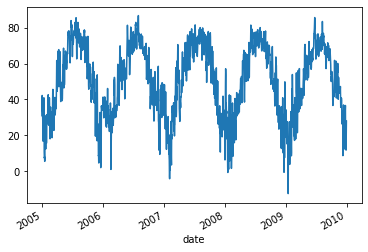

In [37]:
# Example plot of a feature to see why i use KNN Imputer
for key in dict_of_station_dfs:
    dict_of_station_dfs[key]["mean_temp"].plot()
    break

In [38]:
# Fill all missing dates and values
for key, station_df in dict_of_station_dfs.items():
    dict_of_station_dfs[key] = fill_missing_dates_and_values(station_df)

### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for should constitute your test set.

In [39]:
import datetime as dt

tomorrow_date = (dt.datetime.today() + dt.timedelta(days=1)) # Tomorrow
the_date = str(tomorrow_date.replace(year = tomorrow_date.year - 15)).split(' ')[0] # Subtract 15 years
the_date

'2009-05-28'

array([[<AxesSubplot:title={'center':'station_number'}>,
        <AxesSubplot:title={'center':'wban_number'}>,
        <AxesSubplot:title={'center':'mean_temp'}>],
       [<AxesSubplot:title={'center':'mean_dew_point'}>,
        <AxesSubplot:title={'center':'mean_sealevel_pressure'}>,
        <AxesSubplot:title={'center':'mean_visibility'}>],
       [<AxesSubplot:title={'center':'mean_wind_speed'}>,
        <AxesSubplot:title={'center':'max_sustained_wind_speed'}>,
        <AxesSubplot:title={'center':'max_gust_wind_speed'}>],
       [<AxesSubplot:title={'center':'max_temperature'}>,
        <AxesSubplot:title={'center':'total_precipitation'}>,
        <AxesSubplot:>]], dtype=object)

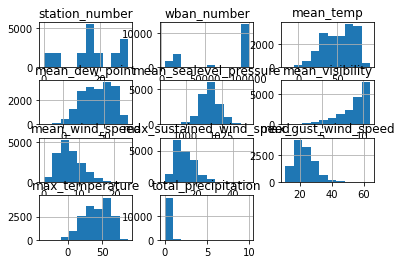

In [40]:
# Test for normal distribution
climate_data_df_filtered_2.hist()

## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

You are allowed to use any library you are comfortable with such as sklearn, tensorflow, keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

In [45]:
for key, station_df in dict_of_station_dfs.items():
    window_size = 7
    X, y = df_to_X_y(station_df, window_size)
    X_train, X_val, X_test, y_train, y_val, y_test, train_dates, val_dates, test_dates = split_data(X, y, station_df)

    number_of_columns = X_train.shape[-1]

    X_train_preprocessed = X_train.copy()
    X_val_preprocessed = X_val.copy()
    X_test_preprocessed = X_test.copy()

    # Not all are normally distributed but to reduce the complexity in this example we use standard scaling
    # Iterate through all columns and scale
    for i in range(number_of_columns):
        mean_of_train = np.mean(X_train[:, :, i])
        std_of_train = np.std(X_train[:, :, i])
        X_train_preprocessed = preprocess(X_train_preprocessed, mean_of_train, std_of_train, i)
        X_val_preprocessed = preprocess(X_val_preprocessed, mean_of_train, std_of_train, i)
        X_test_preprocessed = preprocess(X_test_preprocessed, mean_of_train, std_of_train, i)

    # Build model
    model = build_and_compile_model(window_size, X_train_preprocessed.shape[-1])

    # Train model
    model = fit_model(model, X_train_preprocessed, X_val_preprocessed, y_train, y_val)

    # Predict on the test set
    predictions = model.predict(X_test_preprocessed)

    # Make the final prediction for tomorrow - 15 Years
    final_prediction = predictions[test_dates.get_loc(the_date)][0]

    threshold = 0.5

    final_statement = "no Snow" if final_prediction < threshold else "Snow"

    eval = model.evaluate(X_test_preprocessed, y_test, return_dict=True)

    print()
    print(f"The final prediction for Station {key} is: {final_statement} with an accuracy of {eval['accuracy']:.2f}") #, precision of {eval['precision']:.2f} and recall of {eval['recall']:.2f}.")


12/12 [==============================] - 0s 4ms/step - loss: 0.3860 - accuracy: 0.8830 - precision_9: 0.0000e+00 - recall_9: 0.0000e+00

The final prediction for Station 725305 is: no Snow with an accuracy of 0.88
